# Quantum Teleportation Circuit using Qiskit
## Assignment : Week 1

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler


In [ ]:
# Qubit Definations
q = QuantumRegister(1,"Alice")
e1 = QuantumRegister(1,"a")
e2 = QuantumRegister(1,"b")
c = ClassicalRegister(1,"c")
d = ClassicalRegister(1,"d")
r = ClassicalRegister(1,"Bob")

### Circuit Design

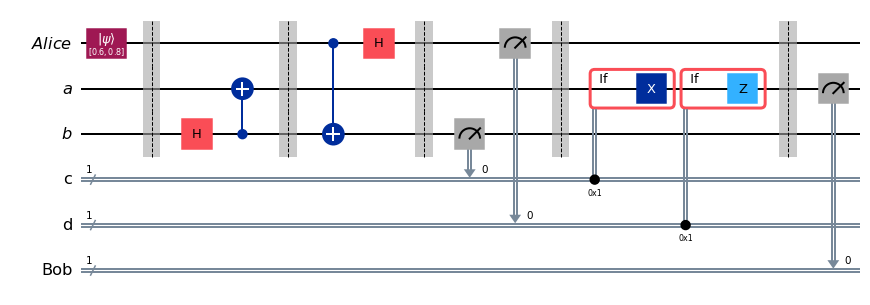

In [ ]:
qc = QuantumCircuit(q,e1,e2,c,d,r)

# Defining Alice's Qubit to be teleported
state = [0.6,0.8]
qc.initialize(state,q)
qc.barrier()

# Entangled Bell State
qc.h(e2)
qc.cx(e2,e1)
qc.barrier()

qc.cx(q,e2)
qc.h(q)
qc.barrier()

qc.measure(e2,c)
qc.measure(q,d)
qc.barrier()

# Bob's conversion based on measure of Alice
with qc.if_test((c,1)):
    qc.x(e1)

with qc.if_test((d,1)):
    qc.z(e1)

qc.barrier()

qc.measure(e1,r)

qc.draw("mpl")


### AER Simulator

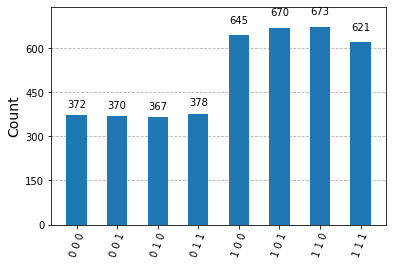

In [4]:
sim = AerSimulator().run(qc,shots = 4096)
result = sim.result()
counts = result.get_counts()
plot_histogram(counts)

1487 2609
[0.363037109375, 0.636962890625]


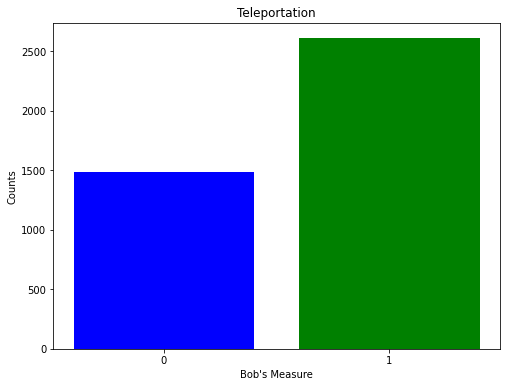

In [ ]:
# Counting the collapsed states Bob gets for probability measurement
counts_0 = sum(value for key, value in counts.items() if key[0] == '0')
counts_1 = sum(value for key, value in counts.items() if key[0] == '1')

print(counts_0, counts_1)
probability = [counts_0/(counts_0 + counts_1), counts_1/(counts_0 + counts_1)]
print(probability)

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.bar(['0', '1'], [counts_0, counts_1], color=['blue', 'green'])
plt.xlabel("Bob's Measure")
plt.ylabel('Counts')
plt.title('Teleportation')
plt.show()

The simulator results for probability fairly match with theoretical probability. It can be given by -
### P(0) = $\frac{|\alpha|^2}{|\alpha|^2 + |\beta|^2}$ 
and 
### P(1) = $\frac{|\beta|^2}{|\alpha|^2 + |\beta|^2}$

In our case, P(0) = 0.36, P(1) = 0.64 $\approx$ simulation

# Actual Quantum Computer

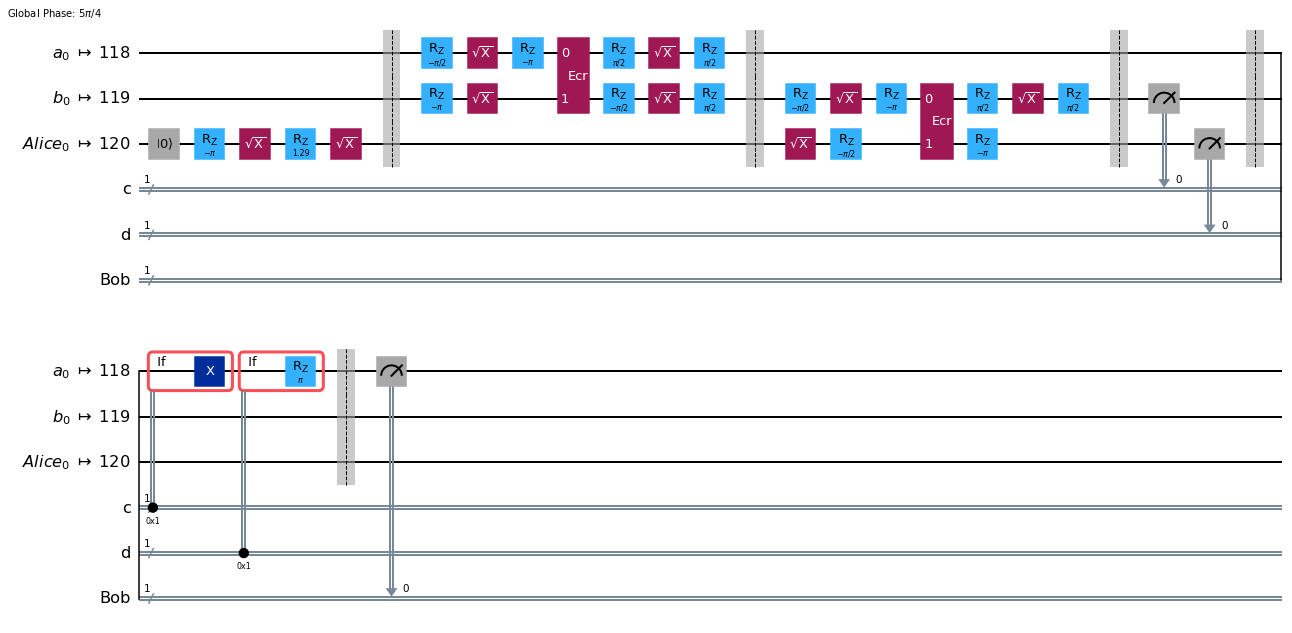

In [ ]:
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

## Estimator Results 

In [ ]:
# Set up six different observables.
observables_labels = ["IZZ", "IXX", "ZII", "XII", "ZZZ", "XXX"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [ ]:
# Construct the Estimator instance.
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against six different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cxfdahtfdnwg008s86vg


In [17]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [18]:
for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [-0.00835987  0.01433121  0.03622611  0.01035032 -0.01990446  0.01592357]


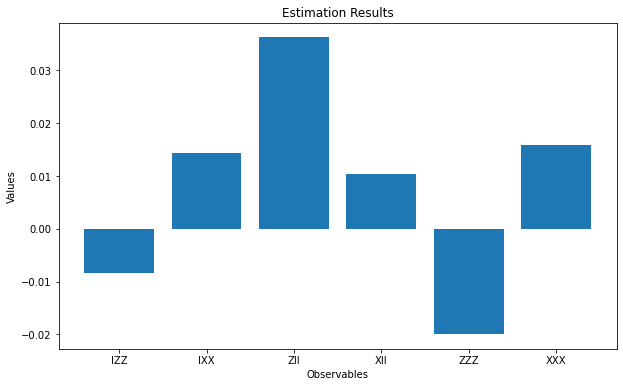

In [20]:
# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(observables_labels,pub_result.data.evs )
plt.xlabel("Observables")
plt.ylabel("Values")
plt.title("Estimation Results")
plt.show()

## Sampler Results 


In [ ]:
sampler = Sampler(mode=backend)

In [ ]:
param_values = np.random.rand(isa_circuit.num_parameters)
job = sampler.run([(isa_circuit, )])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cxfe2tkky7rg0083tbp0
>>> Job Status: QUEUED


In [ ]:
result = job.result()
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=1>), d=BitArray(<shape=(), num_shots=4096, num_bits=1>), Bob=BitArray(<shape=(), num_shots=4096, num_bits=1>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2024-12-15 13:48:07', stop='2024-12-15 13:48:10', size=4096>)])}, 'version': 2})


1539 2557
[0.375732421875, 0.624267578125]


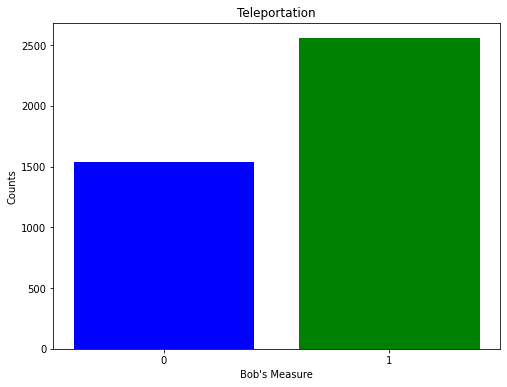

In [ ]:
bitstrings = result[0].data['Bob'].get_bitstrings() # Extracting results for Bob's Measurement

# Again, counting 0's and 1's
counts_0 = bitstrings.count('0')
counts_1 = bitstrings.count('1')
print(counts_0, counts_1)

# Calculating Probability
probability = [counts_0/(counts_0 + counts_1), counts_1/(counts_0 + counts_1)]
print(probability)

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.bar(['0', '1'], [counts_0, counts_1], color=['blue', 'green'])
plt.xlabel("Bob's Measure")
plt.ylabel('Counts')
plt.title('Teleportation')
plt.show()

The results from IBM'S quantum computer have little offset from theoretical value, mainly caused by noise and loss of information at atomic level